In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import walk, getcwd

In [2]:
def get_obs(L, arch, Delta, h, seed):#, entang_spec = False, cutoff = 1e-5):
    # single precision
    precision="single"
    # entropy
    filename = gen_filename("ENT", L, arch, precision, Delta, h, seed)
    ents = np.loadtxt(wdir + filename)
    # local observables
    filename = gen_filename("LocalObservable", L, arch, precision, Delta, h, seed)
    pos, obss = np.loadtxt(wdir + filename, unpack=True) # first array is the list of spin indices
    obss = obss.reshape((-1, int(L))).T # obss[i] = list of local observables for the ith spin index
    # energies
    filename = gen_filename("Energies", L, arch, precision, Delta, h, seed)
    es = np.loadtxt(wdir + filename)
    o_s = np.argsort(es)
#     # entanglement spectrum
#     if entang_spec:
#         filename = gen_filename("EntSpec", L, arch, precision, Delta, h, seed)
#         spec_s = np.loadtxt(wdir + filename, unpack=False)
#         ents_from_spec_s = np.array([S(spec, cutoff) for spec in spec_s])
        
    # double precision
    precision="double"
    # entropy
    filename = gen_filename("ENT", L, arch, precision, Delta, h, seed)
    entd = np.loadtxt(wdir + filename)
    # local observables
    filename = gen_filename("LocalObservable", L, arch, precision, Delta, h, seed)
    pos, obsd = np.loadtxt(wdir + filename, unpack=True) # first array is the list of spin indices
    obsd = obsd.reshape((-1, int(L))).T # obss[i] = list of local observables for the ith spin index
    # energies
    filename = gen_filename("Energies", L, arch, precision, Delta, h, seed)
    ed = np.loadtxt(wdir + filename)
    o_d = np.argsort(ed)

    # get the overlaps
    (r1, r2, rr1, rr2), QF = intersection(es[o_s], ed[o_d])
    print(QF)
    
    obss = [cur_obs[o_s][r1] for cur_obs in obss]
    obsd = [cur_obs[o_d][r2] for cur_obs in obsd]
#     # if we loaded the entanglement spectrum
#     if entang_spec:
#         ents = ents_from_spec_s[:]
    return (es[o_s][r1], ed[o_d][r2]), (ents[o_s][r1], entd[o_d][r2]), (obss, obsd)

In [9]:
def gen_filename(obs, L, arch, precision, Delta, h, seed):
    return obs+".L={:s}.SzTotal=0.arch=eos-{:s}-{:s}.Delta={:s}.h={:s}.pbc.seed={:s}.target0.5.dat".format(L, arch, precision, Delta, h, seed)

def intersection(e1, e2):
    """
    Find the translation of the list e1 and e2 making their data match
    Return: (r1, r2, rr1, rr2), QF
    r1 and r2 are such that e1[r1] and e2[r2] are correctly aligned lists (keeping only the matching data)
    rr1 and rr2 are such that (rr1, e1) and (rr2, e2) are correctly aligned (keeping all the data)
    QF estimates the match quality: QF = min(level spacing)/max(mismatch)
    """
    # D[i][j] = e1[i] - e2[j]
    D = np.abs(e1[:,None] - e2)
    # find i1 i2 such that e1[i1]-e2[i2] is minimal
    i1, i2 = np.unravel_index(np.argmin(D), D.shape)
    # lowest index of the matching data
    imin1 = max(0, i1-i2)
    imin2 = max(0, i2-i1)
    e1t = e1[imin1:]
    e2t = e2[imin2:]
    # highest index of the matching data
    imax = min(len(e1t), len(e2t))
    e1t = e1t[:imax]
    e2t = e2t[:imax]
    
    # average of the min level spacing
    ls1 = np.min((np.sort(e1t) - np.roll(np.sort(e1t),1))[1:])
    ls2 = np.min((np.sort(e2t) - np.roll(np.sort(e2t),1))[1:])
    ls = 0.5*(ls1 + ls2)
#     print("min level spacing = ", ls)
    # maximum mismatch
    mm = np.max(np.abs(e1t - e2t))
#     print("max mismatch = ", mm)
    QF = ls/mm
    
    return [range(imin1, imax+imin1), range(imin2, imax+imin2), range(0, len(e1)), range(imin1-imin2, len(e2)+imin1-imin2)], QF

0.4852830636786459
1.5396298311561685


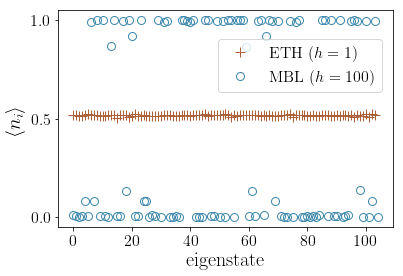

In [29]:
L = '22'
arch = 'strumpack'
Delta = '1'

BostonBlue = [0.2306, 0.5312, 0.6797]
Tuscany = [0.6797, 0.3789, 0.2305]

with plt.style.context(['article-twocolumns']):
    f, ax  = plt.subplots(1)

    h = '1'
    wdir = "/home/nicolas/data/SI-paper/data_strum_22/"

    seed = "445245"
    i = 10
    (Es, Ed), (Ss, Sd), (Os, Od) = get_obs(L, arch, Delta, h, seed)
    p1 = ax.plot(Od[i] + 0.5, '+', markersize=10, color=Tuscany, label = 'ETH ($h=1$)')
    #p2 = ax.plot(Od[i], '+')
    meanSTh = 0.5*(np.mean(Ss) + np.mean(Ss))

    h = '100'
    (Es, Ed), (Ss, Sd), (Os, Od) = get_obs(L, arch, Delta, h, seed)
    ax.plot(Od[i] + 0.5, 'o', label="MBL ($h=100$)", markerfacecolor='none', color=BostonBlue)
    #ax.plot(Od[i], '+')

    #legend_elements = [Line2D([], [], marker='s', markerfacecolor='none', markeredgecolor='black', label='ETH ($h=1$)', color='w'),
    #                   Line2D([0], [0], marker='+', label='double', color='white', markeredgecolor='black')]
    #ax.legend(handles=legend_elements, loc=1, bbox_to_anchor=(0., 0.8, 0.99, .102))

    plt.xlabel("eigenstate")
    plt.legend(loc=1, bbox_to_anchor=(0., 0.8, 0.99, .102))
    ax.set_ylabel(r"$\langle n_i \rangle$")
    ax.set_yticks([0, 0.5, 1])
    plt.savefig('local_observable.pdf')
    plt.show()